<a href="https://colab.research.google.com/github/acse-srm3018/FoamCO2Prediction/blob/main/foamprediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [1]:
%pylab inline
import pandas as pd # for manipulating tabular data
import matplotlib.pyplot as plt # for visualisation
import seaborn as sns # for user friendly visualisation
import numpy as np # for numerical python functionality

Populating the interactive namespace from numpy and matplotlib


# 1. Linear regression

## 1.1 Imports

In [2]:
from sklearn.linear_model import LinearRegression # implementation of linear regression
from sklearn.model_selection import train_test_split # for creating a train and test set
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score # for evaluating our model

## 1.2 Loading the data

# download the data
!wget https://github.com/acse-srm3018/FoamCO2Prediction/blob/main/Data.xlsx

In [4]:
data = pd.read_excel('/content/Data.xlsx')

In [5]:
data.head()

,foam type,initial oil in place,pore volume,Porosity,Permeability,PV,RF,oil flow Rate
0,1.0,97,43.5,34.8,9.0,0.5,5.0,0.190
1,1.0,97,43.5,34.8,9.0,0.7,7.0,0.225
2,1.0,97,43.5,34.8,9.0,1.0,9.5,0.330
3,1.0,97,43.5,34.8,9.0,1.3,11.0,0.075
4,1.0,97,43.5,34.8,9.0,1.7,12.5,0.050


## 1.3 Dimensions and features

In [6]:
data.shape

(213, 8)

In [7]:
data.columns

Index(['foam type', 'initial oil in place', 'pore volume', 'Porosity',
       'Permeability', 'PV', 'RF', 'oil flow Rate'],
      dtype='object')

1.4 Data types

In [8]:
data.info

<bound method DataFrame.info of      foam type  initial oil in place  pore volume  ...    PV    RF  oil flow Rate
0          1.0                    97         43.5  ...   0.5   5.0       0.190000
1          1.0                    97         43.5  ...   0.7   7.0       0.225000
2          1.0                    97         43.5  ...   1.0   9.5       0.330000
3          1.0                    97         43.5  ...   1.3  11.0       0.075000
4          1.0                    97         43.5  ...   1.7  12.5       0.050000
..         ...                   ...          ...  ...   ...   ...            ...
208        5.0                    96         49.0  ...  33.0  40.1       0.001000
209        5.0                    96         49.0  ...  34.0  40.3       0.000400
210        5.0                    96         49.0  ...  34.8  40.5       0.000014
211        5.0                    96         49.0  ...  35.3  40.6       0.000000
212        5.0                    96         49.0  ...  36.3  40.6

### One-hot encoding

Some of these data types are clearly categorical. In order to use categorical features in ML models we would have to [one-hot encode them](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/). This is easy enough to do using the `pd.get_dummies()` function. For more information, [here](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html#) is the documentation. For now, we will simply deal with the numerical features.

In [9]:
# for now we are only going to consider numerical data-types 
data_num = data.select_dtypes(include = 'number')
data_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213 entries, 0 to 212
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   foam type             212 non-null    float64
 1   initial oil in place  213 non-null    int64  
 2   pore volume           213 non-null    float64
 3   Porosity              213 non-null    float64
 4   Permeability          213 non-null    float64
 5   PV                    212 non-null    float64
 6   RF                    213 non-null    float64
 7   oil flow Rate         213 non-null    float64
dtypes: float64(7), int64(1)
memory usage: 13.4 KB


## 1.6 Visualisation

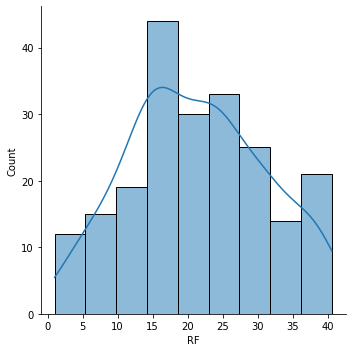

In [10]:
# distribution of target variable(RF)
sns.displot(data_num['RF'], kde=True)

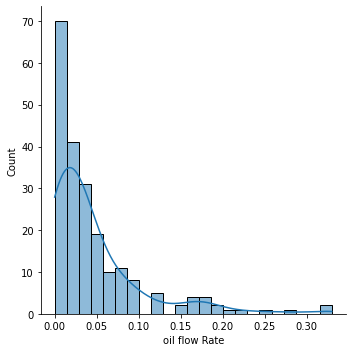

In [11]:
# distribution of target variable(oil flow rate)
sns.displot(data_num['oil flow Rate'], kde=True)

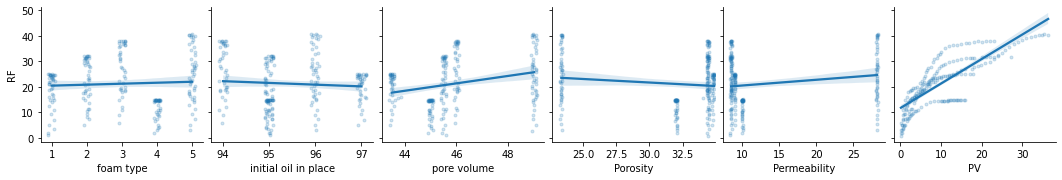

In [13]:
# visualise the relationship between different features and the target variable (RF)
sns.pairplot(data_num, x_vars=data_num.columns.drop('RF')[:6], y_vars=['RF'], markers='.',
             plot_kws={'x_jitter': 0.1, 'y_jitter': 0.1, 'scatter_kws': {'alpha': 0.2}},
             kind='reg')

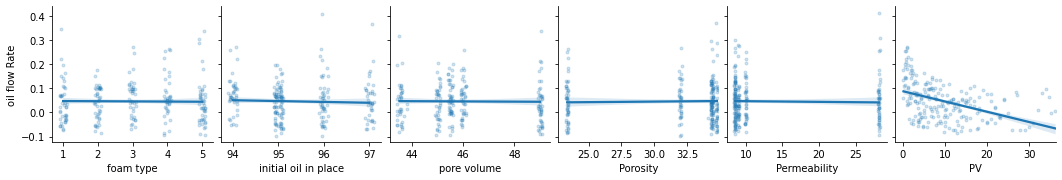

In [15]:
# visualise the relationship between different features and the target variable (RF)
sns.pairplot(data_num, x_vars=data_num.columns.drop('oil flow Rate')[:6], y_vars=['oil flow Rate'], markers='.',
             plot_kws={'x_jitter': 0.1, 'y_jitter': 0.1, 'scatter_kws': {'alpha': 0.2}},
             kind='reg')

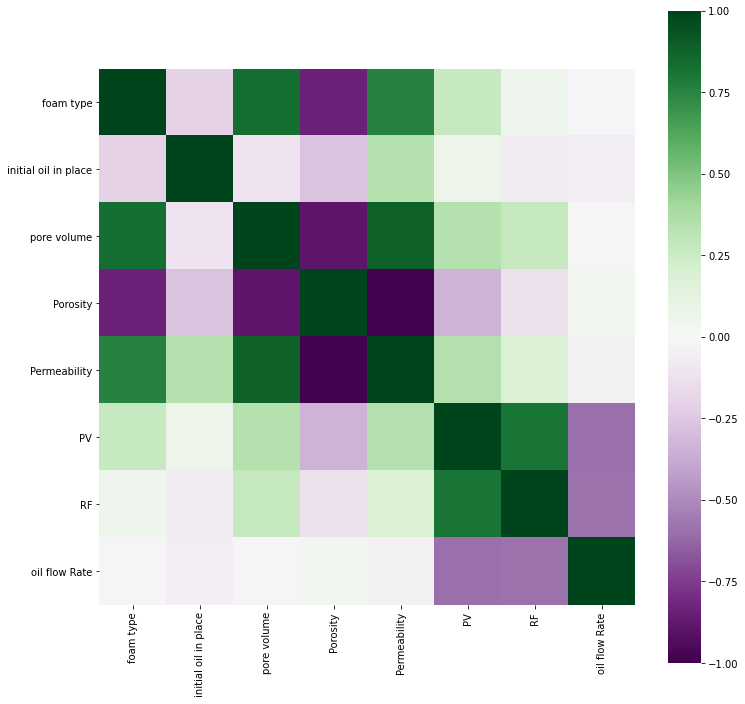

In [17]:
# visualise correlation coefficients
plt.figure(figsize=(12, 12))
sns.heatmap(data_num.corr(), square=True, cmap='PRGn', vmin=-1, vmax=1)

### Multicolinearity

If you are using regression for inference rather than as a predictive tool, it is important to check for [muilticolinearity](https://en.wikipedia.org/wiki/Multicollinearity#Definition). This is when your features are highly correlated with one-another (i.e. the magnitude of the correlation coefficient between them is 0.6 or more). It can cause the regression problem to become ill-conditioned, where coefficients/parameters change dramatically in response to small changes in the data. In practice, this results in incorrect and misleading coefficients/parameters. More on inference later on.

# 1.7 Select features

In [18]:
# correlation with the target variables
data_num.corr()['RF'].abs().sort_values(ascending=False)

RF                      1.000000
PV                      0.812334
oil flow Rate           0.593067
pore volume             0.276299
Permeability            0.186689
Porosity                0.128859
initial oil in place    0.069594
foam type               0.056507
Name: RF, dtype: float64

In [19]:
# correlation with the target variable
data_num.corr()['oil flow Rate'].abs().sort_values(ascending=False)

oil flow Rate           1.000000
PV                      0.599989
RF                      0.593067
initial oil in place    0.060457
Permeability            0.038649
Porosity                0.035960
foam type               0.017151
pore volume             0.014761
Name: oil flow Rate, dtype: float64

In [42]:
# we will then drop all rows containing the remaining missing values 
data_num = data_num.dropna()

In [43]:
# select the 9 most highly correlated features with the target variable to be our features
X = data_num[data_num.corr()['RF'].abs().sort_values(ascending=False)[1:6].index.to_list()]

# select our target variable
y = data_num["RF"]

## 1.8 Train/test split

In [44]:
# perform the train/test split with random_state=123
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=123)

In [45]:
# Check the shapes
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

X_train: (179, 5)
y_train: (179,)
X_test: (32, 5)
y_test: (32,)


## 1.9 Creating our model

In [46]:
# instantiate model class object
model = LinearRegression()

# fit model to the training set
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

## 1.10 Evaluation

In order to evaluate how effective our model is for predictive modelling we need to see how well it performs on unseen data; the test set!

In [47]:
# use our model to generate predictions for the test set
preds_test = model.predict(X_test)

In [48]:
# evaluate how good these predictions are using mae and rmse
mae = mean_absolute_error(y_test, preds_test)
rmse = mean_squared_error(y_test, preds_test, squared=False)

print('MAE:', mae)
print('RMSE:', rmse)

MAE: 2.4689274002392523
RMSE: 3.418791545888212


Here we have used both the mean absolute error and the root mean squared error. The mean absolute error is more robust to outliers than the root mean squared error as it doesn't involve squaring your residuals. However, using the root mean squared error may be preferable if you want to make sure that your models have taken outliers into account. You can read more about these error metrics [here](https://www.dataquest.io/blog/understanding-regression-error-metrics/).

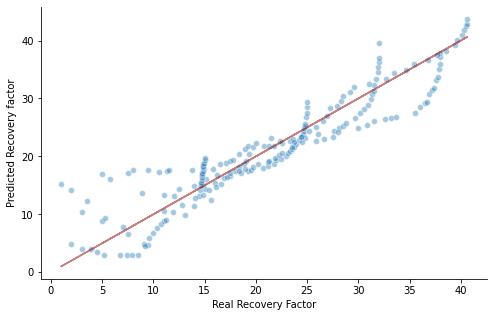

In [50]:
# evaluation can also be done visually by plotting predictions vs the true target
# across the entire dataset
preds = model.predict(X)

plt.figure(figsize=(8,5))
plt.scatter(y, preds, alpha=0.4, linewidths=1, edgecolors='white')
plt.plot(y, y, color='darkred', alpha=0.5)
plt.xlabel('Real Recovery Factor')
plt.ylabel('Predicted Recovery factor')
sns.despine()

## 1.11 Inference 

So far we have been using linear regression purely as a predictive tool. However, one of the main advantageous of linear regression is that it is incredibely useful for inference. This is where we use our model to try and understand how the target variable was generated from our features, rather than just predicting it. You can read more about the differences between prediction and inference here.

The reason linear regression is great for inference is that we can easily interpret the meaning of the parameters/coefficients of our model.

In [53]:
# instantiate model class object
model = LinearRegression()

# when using regression for inference you should fit your model to the entire dataset
model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [51]:
# when using regression for inference it is more common to use the R-squared metric for evaluation 
# this is also typically done on the whole dataset (rather than a separate test set)
# it is a measure of how much variance in the target variable our model is able to explain 
r2 = r2_score(y, preds)
r2

0.8654328689247712

In [52]:
# lets have a look at our models parameters or coefficients
params = pd.DataFrame({'Features': X.columns, 'Coefficients': model.coef_})
params

,Features,Coefficients
0,PV,0.813664
1,oil flow Rate,-32.686730
2,pore volume,3.107010
3,Permeability,2.236208
4,Porosity,5.294762
